In [1]:
import os
import sys


notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from scripts.utils import merge_frames
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")


context = pd.read_csv("../data/context_df.csv")
pq = pd.read_parquet("../data/test_task.parquet")
percent_columns = [
	"inflation", "key_rate", "deposit_1", "deposit_3", "deposit_6", "deposit_12",
	"fa_delta", "usd_delta", "IMOEX_delta", "RGBI_delta"
    ]
df = merge_frames(pq, context)
df.head()

,date,cus_class,quarter_idx,context_data_from,context_data_to,quarter,inflation,key_rate,deposit_1,deposit_3,deposit_6,deposit_12,fa_delta,usd_delta,IMOEX_delta,RGBI_delta
0,2016-07-01,105.0,0,2016-07-01,2016-09-30,3,7.34,10.5,6.14,7.05,6.86,8.17,1.52,-5.3,1.85,2.48
1,2016-07-01,1.0,0,2016-07-01,2016-09-30,3,7.34,10.5,6.14,7.05,6.86,8.17,1.52,-5.3,1.85,2.48
2,2016-07-01,103.0,0,2016-07-01,2016-09-30,3,7.34,10.5,6.14,7.05,6.86,8.17,1.52,-5.3,1.85,2.48
3,2016-07-01,106.0,0,2016-07-01,2016-09-30,3,7.34,10.5,6.14,7.05,6.86,8.17,1.52,-5.3,1.85,2.48
4,2016-07-01,106.0,0,2016-07-01,2016-09-30,3,7.34,10.5,6.14,7.05,6.86,8.17,1.52,-5.3,1.85,2.48


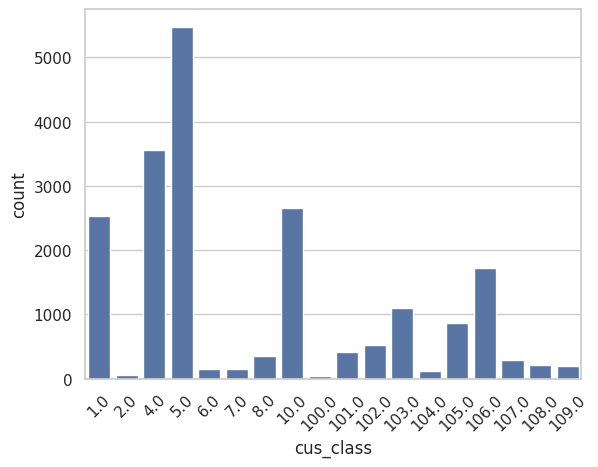

In [3]:
# Распределение классов
sns.countplot(data=df, x="cus_class")
plt.xticks(rotation=45)
plt.show()


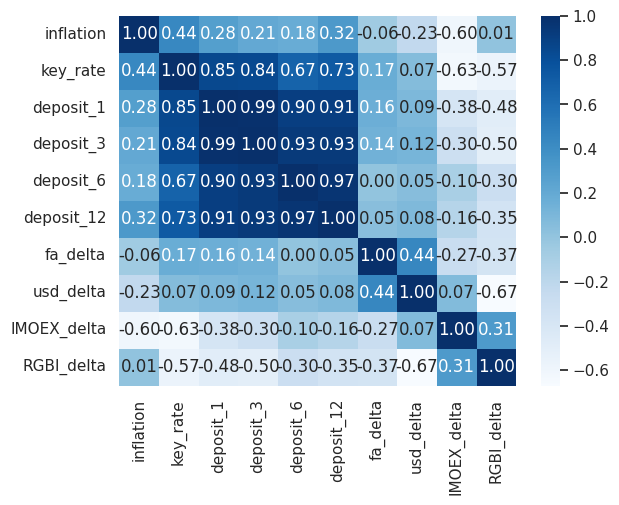

In [4]:
# Корреляционная матрица макропоказателей
sns.heatmap(
    df[percent_columns].corr(),
    annot=True,
    fmt=".2f",
    cmap="Blues"
)
plt.show()

In [5]:
# Временной тренд по ключевой ставке
"""plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="date", y="key_rate")
plt.show()
"""

'plt.figure(figsize=(10, 5))\nsns.lineplot(data=df, x="date", y="key_rate")\nplt.show()\n'

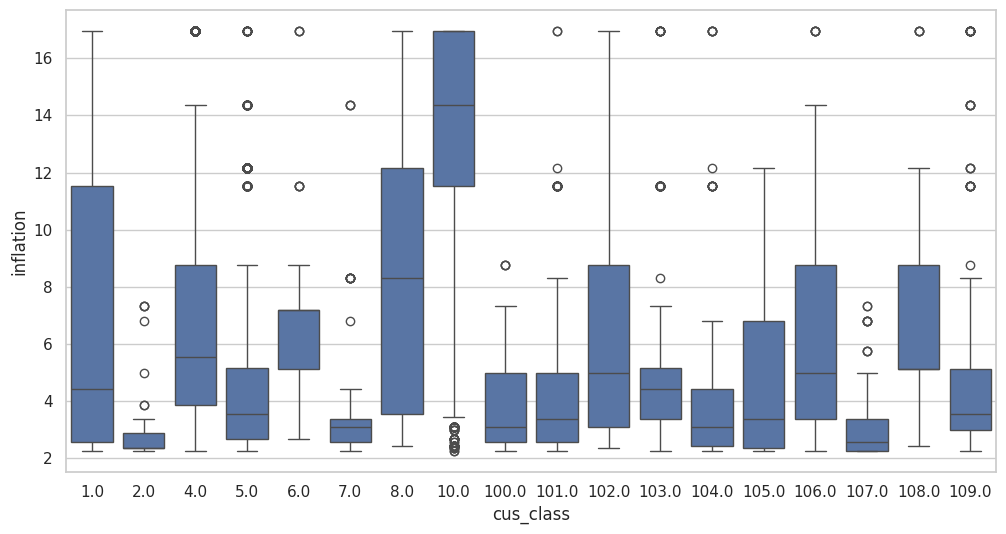

In [6]:
# Boxplot инфляции по классам
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="cus_class", y="inflation")
plt.show()

In [7]:
df_fe = df.copy()

# Сезонные признаки
df_fe["year"] = df_fe["date"].dt.year
df_fe["month"] = df_fe["date"].dt.month
df_fe["quarter"] = df_fe["date"].dt.quarter

# Feature engineering
df_fe["deposit_spread"] = df_fe["deposit_12"] - df_fe["deposit_1"]
df_fe["usd_inverted"] = -df_fe["usd_delta"]
df_fe["fa_vs_usd"] = df_fe["fa_delta"] - df_fe["usd_delta"]

# Квартальное изменение инфляции внутри группы
df_fe = df_fe.sort_values(by=["quarter_idx", "date"])
df_fe["diff_inflation"] = df_fe.groupby("quarter_idx")["inflation"].diff().fillna(0)

base_percent_columns = [
    "inflation", "key_rate", "deposit_1", "deposit_3", "deposit_6", "deposit_12",
    "fa_delta", "usd_delta", "IMOEX_delta", "RGBI_delta"
]
engineered_columns = [
    "deposit_spread", "usd_inverted", "fa_vs_usd", "diff_inflation",
    "year", "month", "quarter"
]
final_columns = base_percent_columns + engineered_columns


X = df_fe[final_columns].values
y = df_fe["cus_class"].astype(int).values

In [8]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_fe[final_columns].values)

In [9]:
# Стратифицированный сплит по кварталу
from sklearn.model_selection import train_test_split


# Train + Val/Test
train_idx, temp_idx = train_test_split(
    df_fe.index,
    test_size=0.4,
    stratify=df_fe["quarter"],
    random_state=42
)

# Val + Test
val_quarters = df_fe.loc[temp_idx, "quarter"]
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=val_quarters,
    random_state=42
)


X_train = X_scaled[train_idx]
y_train = y[train_idx]

X_val = X_scaled[val_idx]
y_val = y[val_idx]

X_test = X_scaled[test_idx]
y_test = y[test_idx]


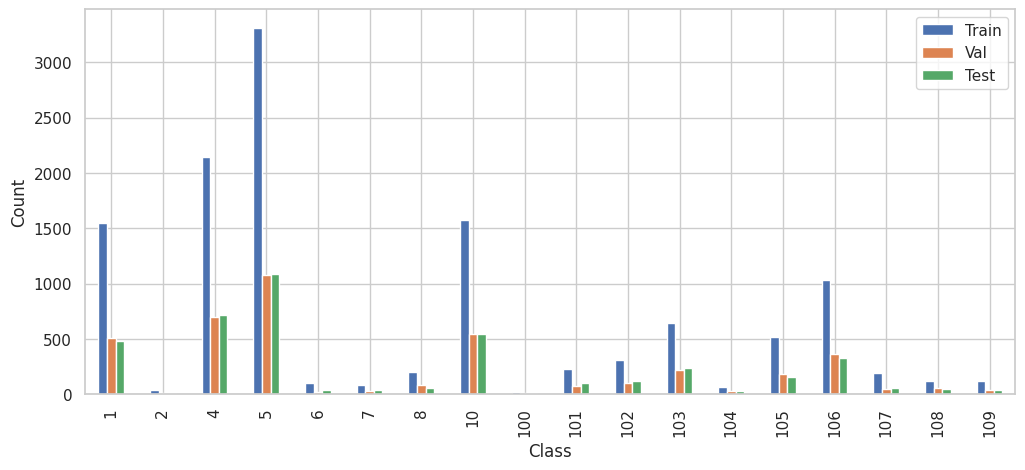

In [10]:
def plot_class_distribution(y_splits, labels):
    dist_df = pd.DataFrame({
        label: pd.Series(y).value_counts().sort_index()
        for y, label in zip(y_splits, labels)
    }).fillna(0).astype(int)

    dist_df.plot(kind="bar", figsize=(12, 5))
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution(
    y_splits=[y_train, y_val, y_test],
    labels=["Train", "Val", "Test"]
)


In [11]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_fe["cus_class"].astype(int))
y = y_encoded

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]


In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import mlflow
import mlflow.pytorch


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)


class BetterMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BetterMLP(input_dim=X_train.shape[1], output_dim=len(np.unique(y_train))).to(device)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)


In [16]:
from mlflow.models import infer_signature


mlflow.set_experiment("better_mlp_experiment")
with mlflow.start_run():
    for epoch in range(10):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        # Валидация
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                preds = model(xb).argmax(dim=1).cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(yb.numpy())

        f1_macro = f1_score(y_true, y_pred, average="macro")
        f1_micro = f1_score(y_true, y_pred, average="micro")
        print(f"Epoch {epoch}: loss={avg_train_loss:.4f}, F1_macro={f1_macro:.4f}, F1_micro={f1_micro:.4f}")

        mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
        mlflow.log_metric("f1_macro", f1_macro, step=epoch)
        mlflow.log_metric("f1_micro", f1_micro, step=epoch)

    mlflow.log_param("model", "better_mlp")
    mlflow.log_param("architecture", "128-64 with ReLU, BN, Dropout, class_weight")


    input_example = torch.tensor(X_train[:5], dtype=torch.float32).to(device)
    output_example = model(input_example).cpu().detach().numpy()

    mlflow.pytorch.log_model(
        model, name="better_mlp",
        signature=infer_signature(X_train[:5], output_example),
    )

Epoch 0: loss=2.1630, F1_macro=0.1587, F1_micro=0.2736
Epoch 1: loss=2.1798, F1_macro=0.1576, F1_micro=0.2663
Epoch 2: loss=2.1646, F1_macro=0.1700, F1_micro=0.2966
Epoch 3: loss=2.1563, F1_macro=0.1567, F1_micro=0.2648
Epoch 4: loss=2.1552, F1_macro=0.1735, F1_micro=0.2876
Epoch 5: loss=2.1529, F1_macro=0.1789, F1_micro=0.3377
Epoch 6: loss=2.1726, F1_macro=0.1642, F1_micro=0.2851
Epoch 7: loss=2.1646, F1_macro=0.1739, F1_micro=0.3409
Epoch 8: loss=2.1490, F1_macro=0.1710, F1_micro=0.3059
Epoch 9: loss=2.1537, F1_macro=0.1653, F1_micro=0.2966


In [18]:
from sklearn.metrics import classification_report, f1_score


X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Валидация на тесте
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred_test = outputs.argmax(dim=1).cpu().numpy()

f1_macro_test = f1_score(y_test, y_pred_test, average="macro")
f1_micro_test = f1_score(y_test, y_pred_test, average="micro")

print("Test F1 macro:", round(f1_macro_test, 4))
print("Test F1 micro:", round(f1_micro_test, 4))
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_.astype(str), zero_division=0))


Test F1 macro: 0.1652
Test F1 micro: 0.2934
              precision    recall  f1-score   support

           1       0.40      0.19      0.26       481
           2       0.05      0.40      0.08        15
           4       0.00      0.00      0.00       717
           5       0.62      0.31      0.42      1086
           6       0.09      0.64      0.15        39
           7       0.07      0.62      0.12        34
           8       0.02      0.03      0.03        60
          10       0.62      0.88      0.73       543
         100       0.00      0.00      0.00         9
         101       0.00      0.00      0.00        99
         102       0.08      0.23      0.12       116
         103       0.29      0.39      0.33       235
         104       0.01      0.07      0.02        27
         105       0.35      0.41      0.38       157
         106       0.16      0.04      0.07       332
         107       0.09      0.36      0.15        56
         108       0.06      0.36    